### Multilabel Classification com Keras

O objetivo deste notebook é classificar a minha presença e/ou o da minha esposa, nas fotos do nosso casamento.
Comparamos o desempenho de abordagens treinando uma rede convolucional do inicio, com Keras, para fazer a classificação e fazendo fine-tuning de uma rede pré-treinada.

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

import re
import os
import cv2 as cv

2023-03-02 17:34:09.554977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/oracle/instantclient_19_9:
2023-03-02 17:34:09.555003: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Importa dados

In [2]:
BATCH_SIZE = 32

# Entrada da rede e tamanho das imagens
input_shape = (150, 150, 3)

In [3]:
def structure_images(path_to_subset):
    
    # Listas pra salvar as imagens e rotulos
    X = []
    Y = []

    # Itera sobre as classes no diretorio
    for folder in os.listdir(path_to_subset):

        # Le as imagens da classe e carrega em X e Y
        for image in os.listdir(os.path.join(path_to_subset, folder)):
            path_to_image = os.path.join(path_to_subset, folder, image)
            image = cv.imread(path_to_image)    
            image = cv.resize(image, (input_shape[0], input_shape[1]))
            label = [folder]
            if '_' in folder:
                label = folder.split('_')

            X.append(image)
            Y.append(label)

    X = np.array(X)
    Y = np.array(Y)
    
    return(X, Y)

In [4]:
x_train, y_train = structure_images('./pessoas/train')

/tmp/ipykernel_933654/4285378919.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y)


In [5]:
x_val, y_val = structure_images('./pessoas/test')

/tmp/ipykernel_933654/4285378919.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y)


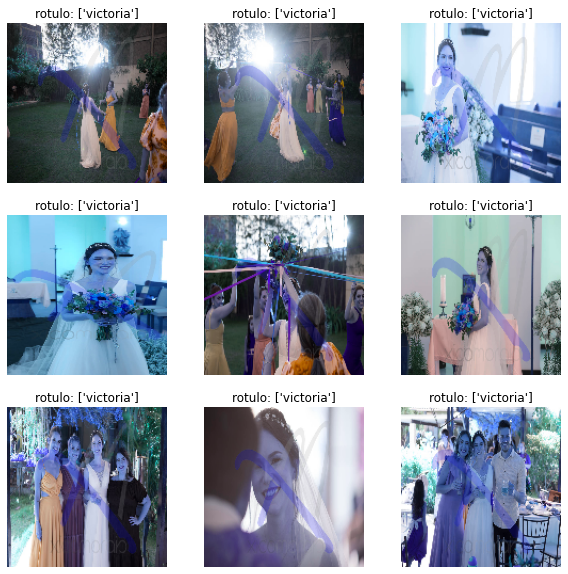

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i])
    plt.title('rotulo: ' + str(y_train[i]))
    plt.axis("off")
plt.show()

#### Formata rótulos pra classificacao multilabel

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, stratify = y_train, shuffle = True, random_state=3)

In [9]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1818, 150, 150, 3) (1818, 2)
(683, 150, 150, 3) (683, 2)


#### Formata dados

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

2023-03-02 17:34:27.328139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dshome/venv/lib/python3.8/site-packages/cv2/../../lib64:/opt/oracle/instantclient_19_9:
2023-03-02 17:34:27.328167: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-02 17:34:27.328182: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ec2-sa1-1b-p-analetslytics-dev): /proc/driver/nvidia/version does not exist
2023-03-02 17:34:27.328424: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the 

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.batch(BATCH_SIZE).repeat().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).repeat().prefetch(buffer_size=AUTOTUNE)

### Carrega funções de preprocessamento

In [12]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(input_shape[0], input_shape[1]),
    layers.Rescaling(1./255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

In [14]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# Classifica observacoes de teste
def predict_labels(model, x_test):
    preds = model.predict(x_test)
    preds = np.where(preds < 0.5, 0, 1)
    return(preds)

### Modela rede

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout

model = Sequential()

model.add(resize_and_rescale)
model.add(data_augmentation)

model.add(Conv2D(16, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(len(mlb.classes_), activation = 'sigmoid'))

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

optimizer = Adam() 
precision = Precision()
recall = Recall()

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[precision, recall])

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Checkpoint pra salvar o melhor modelo
checkpoint = ModelCheckpoint('./best_model.hdf5', save_best_only = True, monitor = 'val_loss')

# Early Stopping pra evitar overfitting
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

# Ajustar o learning rate com Performance Scheduling
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    # steps_per_epoch=step_size_train,
    
    validation_data = val_dataset,
    # validation_steps=step_size_val,
    validation_steps=len(x_val) // BATCH_SIZE,
    
    epochs = 80, 
    callbacks = [checkpoint, early_stopping, lr_scheduler],
)

Epoch 1/80
56/56 [==============================] - 10s 163ms/step - loss: 0.8895 - precision: 0.8691 - recall: 0.5660 - val_loss: 0.6646 - val_precision: 0.9062 - val_recall: 0.5506 - lr: 0.0010
Epoch 2/80
56/56 [==============================] - 9s 159ms/step - loss: 0.6978 - precision: 0.8851 - recall: 0.6618 - val_loss: 1.1986 - val_precision: 0.9062 - val_recall: 0.5506 - lr: 0.0010
Epoch 3/80
56/56 [==============================] - 9s 159ms/step - loss: 0.6032 - precision: 0.8905 - recall: 0.7459 - val_loss: 1.7360 - val_precision: 0.9062 - val_recall: 0.5506 - lr: 0.0010
Epoch 4/80
56/56 [==============================] - 9s 160ms/step - loss: 0.5283 - precision: 0.8881 - recall: 0.8236 - val_loss: 2.0928 - val_precision: 0.9062 - val_recall: 0.5506 - lr: 0.0010
Epoch 5/80
56/56 [==============================] - 9s 160ms/step - loss: 0.4726 - precision: 0.8880 - recall: 0.8618 - val_loss: 1.8871 - val_precision: 0.9062 - val_recall: 0.5506 - lr: 0.0010
Epoch 6/80
56/56 [======

#### Plota dados do treino

<AxesSubplot:>

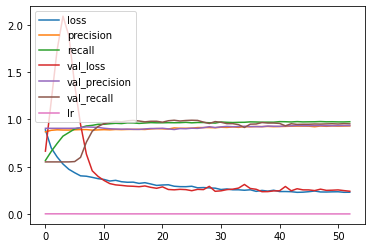

In [18]:
# Plot os resultados do treino
history = pd.DataFrame(history.history)
history.plot()

#### Carrega modelo 

In [19]:
# Load o melhor modelo
model.load_weights('./best_model.hdf5')

# Salva o modelo para usar depois
model.save('./best_model.hdf5')

#### Avalia modelo no teste

In [20]:
# model_preds = predict_labels(model, test_dataset)
model_preds = predict_labels(model, x_test)

# Cria matriz de confusao
confusion = multilabel_confusion_matrix(y_test, model_preds)
confusion

array([[[ 50,   3],
        [  9, 141]],

       [[  0,  17],
        [  0, 186]]])

In [21]:
precision_recall_fscore_support(y_test, model_preds, average='micro')

(0.9423631123919308, 0.9732142857142857, 0.9575402635431918, None)

In [22]:
accuracy_score(y_test, model_preds)

0.8571428571428571

### Fine Tuning de rede pré-treinada

In [23]:
base_model = tf.keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=input_shape,
    include_top=False)

In [24]:
base_model.trainable = False

In [25]:
inputs = tf.keras.Input(shape=input_shape)

x = data_augmentation(inputs)
x = resize_and_rescale(x)

# Executa em modo de inferencia (sem atualizar os pesos da rede pretreinada)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(2, activation = 'sigmoid')(x)
tl_model = tf.keras.Model(inputs, outputs)

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

optimizer = Adam() 
precision = Precision()
recall = Recall()
loss = tf.keras.losses.BinaryCrossentropy()
tl_model.compile(optimizer=optimizer, loss=loss, metrics=[precision, recall]) 


In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Checkpoint pra salvar o melhor modelo
checkpoint = ModelCheckpoint('./best_model_tl.hdf5', save_best_only = True, monitor = 'val_loss')

# Early Stopping pra evitar overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Ajustar o learning rate com Performance Scheduling
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

tl_history_1 = tl_model.fit(
    train_dataset,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    
    validation_data = val_dataset,
    validation_steps=len(x_val) // BATCH_SIZE,
    
    epochs = 40, 
    callbacks = [checkpoint, early_stopping, lr_scheduler],
)

Epoch 1/40
56/56 [==============================] - 68s 1s/step - loss: 1.2436 - precision_1: 0.8641 - recall_1: 0.8656 - val_loss: 0.7469 - val_precision_1: 0.8916 - val_recall_1: 0.9150 - lr: 0.0010
Epoch 2/40
56/56 [==============================] - 68s 1s/step - loss: 0.4798 - precision_1: 0.9226 - recall_1: 0.9347 - val_loss: 0.5065 - val_precision_1: 0.9220 - val_recall_1: 0.9304 - lr: 0.0010
Epoch 3/40
56/56 [==============================] - 67s 1s/step - loss: 0.3221 - precision_1: 0.9410 - recall_1: 0.9550 - val_loss: 0.3917 - val_precision_1: 0.9345 - val_recall_1: 0.9412 - lr: 0.0010
Epoch 4/40
56/56 [==============================] - 68s 1s/step - loss: 0.2373 - precision_1: 0.9548 - recall_1: 0.9628 - val_loss: 0.3198 - val_precision_1: 0.9358 - val_recall_1: 0.9485 - lr: 0.0010
Epoch 5/40
56/56 [==============================] - 67s 1s/step - loss: 0.1815 - precision_1: 0.9620 - recall_1: 0.9685 - val_loss: 0.2720 - val_precision_1: 0.9430 - val_recall_1: 0.9575 - lr: 0.

<AxesSubplot:>

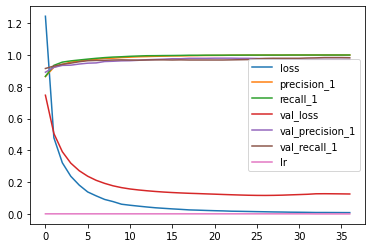

In [28]:
tl_history_1_df = pd.DataFrame(tl_history_1.history)
tl_history_1_df.plot()

In [29]:
# Load o melhor modelo
tl_model.load_weights('./best_model_tl.hdf5')

In [30]:
base_model.trainable = True

optimizer = tf.keras.optimizers.Adam(1e-5)  # Low learning rate
loss = tf.keras.losses.BinaryCrossentropy()
tl_model.compile(optimizer=optimizer, loss=loss, metrics=[precision, recall]) 

In [31]:
tl_history_2 = tl_model.fit(
    train_dataset,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    
    validation_data = val_dataset,
    validation_steps=len(x_val) // BATCH_SIZE,
    
    epochs = 5, 
    callbacks = [checkpoint, early_stopping, lr_scheduler],
)

Epoch 1/5
56/56 [==============================] - 239s 4s/step - loss: 0.0645 - precision_1: 0.9817 - recall_1: 0.9882 - val_loss: 0.1070 - val_precision_1: 0.9890 - val_recall_1: 0.9711 - lr: 1.0000e-05
Epoch 2/5
56/56 [==============================] - 237s 4s/step - loss: 0.0178 - precision_1: 0.9960 - recall_1: 0.9986 - val_loss: 0.0572 - val_precision_1: 0.9910 - val_recall_1: 0.9919 - lr: 1.0000e-05
Epoch 3/5
56/56 [==============================] - 237s 4s/step - loss: 0.0070 - precision_1: 0.9997 - recall_1: 0.9997 - val_loss: 0.0563 - val_precision_1: 0.9927 - val_recall_1: 0.9901 - lr: 1.0000e-05
Epoch 4/5
56/56 [==============================] - 237s 4s/step - loss: 0.0057 - precision_1: 0.9993 - recall_1: 0.9997 - val_loss: 0.0568 - val_precision_1: 0.9883 - val_recall_1: 0.9901 - lr: 1.0000e-05
Epoch 5/5
56/56 [==============================] - 237s 4s/step - loss: 0.0034 - precision_1: 0.9997 - recall_1: 0.9997 - val_loss: 0.0512 - val_precision_1: 0.9892 - val_recall_1:

In [32]:
# Load o melhor modelo
tl_model.load_weights('./best_model_tl.hdf5')

# Salva o modelo para usar depois
tl_model.save('./best_model_tl.hdf5')

<AxesSubplot:>

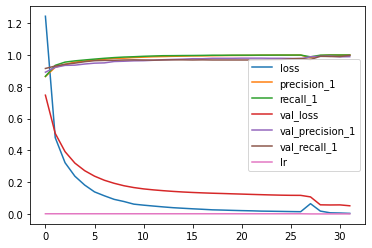

In [33]:
tl_history_2_df = pd.concat([tl_history_1_df.iloc[0:(tl_history_1_df.val_loss.idxmin()+1)], pd.DataFrame(tl_history_2.history)]).reset_index(drop=True)
tl_history_2_df.plot()

#### Avalia modelo TL no teste

In [34]:
tl_preds = predict_labels(tl_model, x_test)

# Cria matriz de confusao
confusion = multilabel_confusion_matrix(y_test, tl_preds)
confusion

array([[[ 52,   1],
        [  1, 149]],

       [[ 15,   2],
        [  0, 186]]])

In [35]:
precision_recall_fscore_support(y_test, tl_preds, average='micro')

(0.9911242603550295, 0.9970238095238095, 0.9940652818991098, None)

In [36]:
accuracy_score(y_test, tl_preds)

0.9802955665024631

#### Mostra imagens com classe real e prevista da melhor abordagem (Transfer Learning)

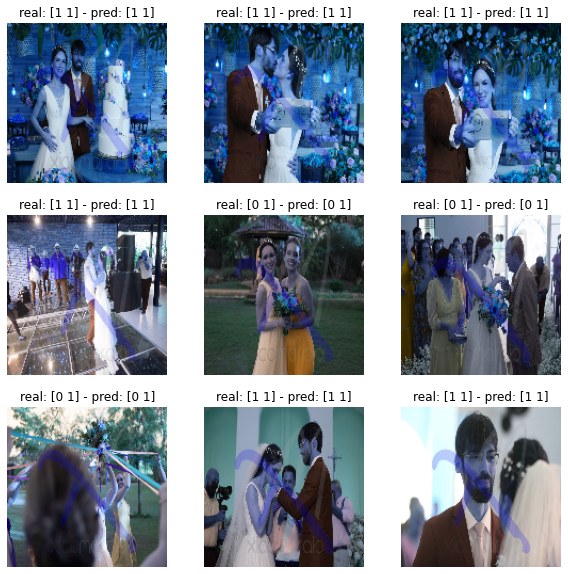

In [37]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_test[i])
    plt.title('real: ' + str(y_test[i])+ " - pred: "+ str(tl_preds[i]))
    plt.axis("off")
plt.show()

#### Previsoes problematicas

In [38]:
erro_allan = []
erro_victoria = []
erro_ambos = []
acerto = []
for i in range(0, len(y_test)):
    
    if np.array_equal(y_test[i], tl_preds[i]):
        acerto.append(i)
        continue
        
    if (y_test[i][0] != tl_preds[i][0]) & (y_test[i][1] != tl_preds[i][1]):
        erro_ambos.append(i)
        continue
        
    if (y_test[i][0] != tl_preds[i][0]):
        erro_allan.append(i)
        continue
    
    if (y_test[i][1] != tl_preds[i][1]):
        erro_victoria.append(i)
        continue
        

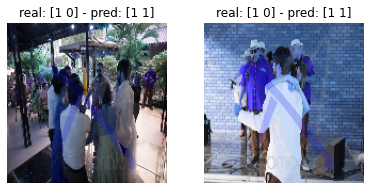

In [39]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(0,min(9,len(erro_victoria))):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_test[erro_victoria[i]])
    # plt.title('real: ' + str(y_test[erro_victoria[i]])+ " - pred: "+ str(tl_preds[erro_victoria[i]]))
    plt.title('real: ' + str(y_test[erro_victoria[i]])+ " - pred: "+ str(model_preds[erro_victoria[i]]))
    plt.axis("off")
plt.show()


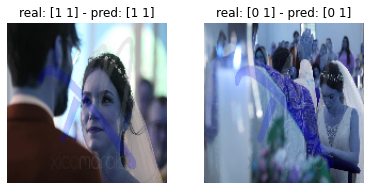

In [40]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(0,min(9,len(erro_allan))):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_test[erro_allan[i]])
    # plt.title('real: ' + str(y_test[erro_allan[i]])+ " - pred: "+ str(tl_preds[erro_allan[i]]))
    plt.title('real: ' + str(y_test[erro_allan[i]])+ " - pred: "+ str(model_preds[erro_allan[i]]))
    plt.axis("off")
plt.show()


### Explicações das previsões (LIME)

In [41]:
from lime import lime_image
import time

from skimage.segmentation import mark_boundaries

In [42]:
explainer = lime_image.LimeImageExplainer()

#### Acerto

In [43]:
tmp = time.time()

explanation_acerto = explainer.explain_instance(x_test[acerto[1]]/255., tl_model.predict, top_labels=2, hide_color=0, num_samples=1000)
print(time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

30.912805318832397


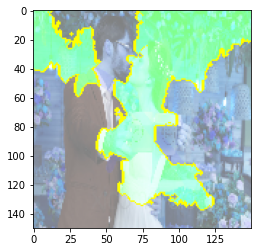

In [44]:
temp_acerto_allan, mask_acerto_allan = explanation_acerto.get_image_and_mask(explanation_acerto.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_acerto_allan / 2 + 0.5, mask_acerto_allan))

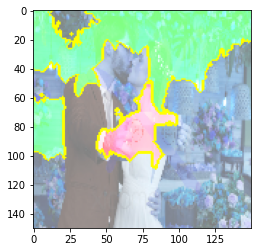

In [45]:
temp_acerto_victoria, mask_acerto_victoria = explanation_acerto.get_image_and_mask(explanation_acerto.top_labels[1], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_acerto_victoria / 2 + 0.5, mask_acerto_victoria))

#### Erro allan

In [46]:
predict_labels(tl_model, x_test[erro_allan[0:1]])

array([[0, 1]])

In [47]:
tmp = time.time()

explanation_er_al = explainer.explain_instance(x_test[erro_allan[0]]/255., tl_model.predict, hide_color=None, num_samples=1000)
print(time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

30.275419235229492


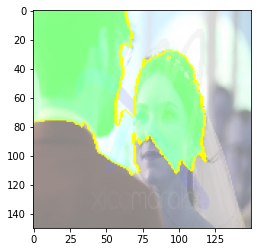

In [55]:
temp_er_al_al, mask_er_al_al = explanation_er_al.get_image_and_mask(explanation_er_al.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_er_al_al / 2 + 0.5, mask_er_al_al))

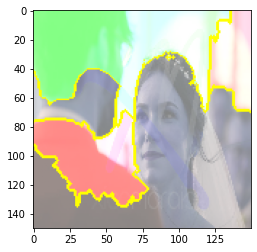

In [49]:
temp_er_al_vi, mask_er_al_vi = explanation_er_al.get_image_and_mask(explanation_er_al.top_labels[1], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_er_al_vi / 2 + 0.5, mask_er_al_vi))

#### Erro Victoria

In [50]:
predict_labels(tl_model, x_test[erro_victoria[0:1]])

array([[1, 1]])

In [51]:
tmp = time.time()

explanation_er_vi = explainer.explain_instance(x_test[erro_victoria[0]]/255., tl_model.predict, hide_color=None, num_samples=1000)
print(time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

30.813867807388306


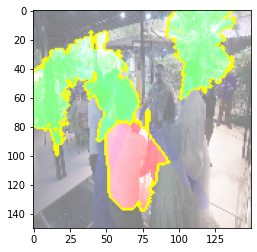

In [52]:
temp_er_vi_al, mask_er_vi_al = explanation_er_vi.get_image_and_mask(explanation_er_vi.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_er_vi_al / 2 + 0.5, mask_er_vi_al))

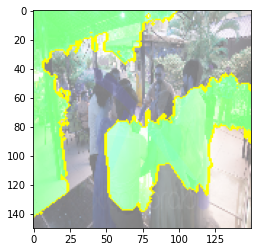

In [58]:
temp_er_vi_vi, mask_er_vi_vi = explanation_er_vi.get_image_and_mask(explanation_er_vi.top_labels[1], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_er_vi_vi / 2 + 0.5, mask_er_vi_vi))